In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

def encode_labels(labels, max_len=3):
    n = len(labels)
    length = len(labels[0])
    char_map = dict(zip(unique_characters, range(len(unique_characters))))
    one_hot = np.zeros([n, length, len(unique_characters)])
    for i, label in enumerate(labels):
        m = np.zeros([length, len(unique_characters)])
        for j, char in enumerate(label):
            m[j, char_map[char]] = 1
        one_hot[i] = m

    return one_hot

def decode_labels(labels):
    pred = np.argmax(labels, axis=-1)
    predicted = ''.join([unique_characters[i] for i in pred])

    return predicted

def onehot_to_integers(labels):
    argmaxes = np.argmax(labels, axis=-1)
    string_list = [''.join([unique_characters[i] for i in pred]) for pred in argmaxes]
    edge_cases = {'-  ': '100'}
    for edge_case, solution in edge_cases.items():
        string_list = [string.replace(edge_case, solution) for string in string_list]

    return np.array([int(item) for item in string_list])


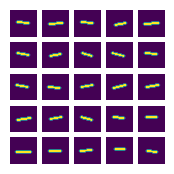

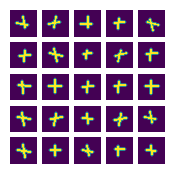

In [ ]:
from scipy.ndimage import rotate

def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)       # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -||-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -50, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images


In [ ]:
def create_data(highest_integer, num_addends=2, operands=['+', '-']):

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_characters[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_answer_length, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len=3, pad_right=False):
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


(10000,) (10000, 5, 28, 28) (10000,) (10000, 4, 28, 28)
Query #988

X_text: "9*88 " = y_text: "792 "


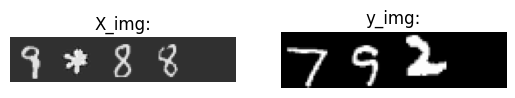

Query #7280

X_text: "72*80" = y_text: "5760"


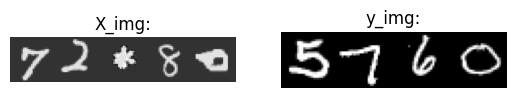

Query #691

X_text: "6*91 " = y_text: "546 "


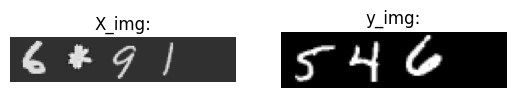

Query #6232

X_text: "62*32" = y_text: "1984"


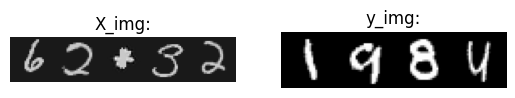

Query #8629

X_text: "86*29" = y_text: "2494"


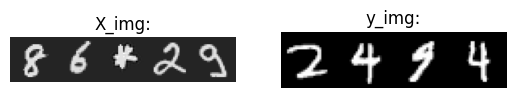

Query #8287

X_text: "82*87" = y_text: "7134"


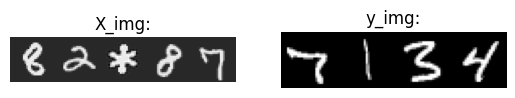

Query #2300

X_text: "23*0 " = y_text: "0   "


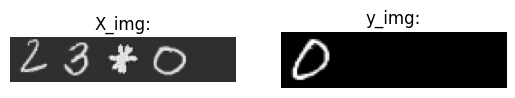

Query #3604

X_text: "36*4 " = y_text: "144 "


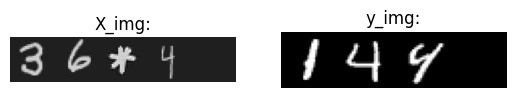

Query #9486

X_text: "94*86" = y_text: "8084"


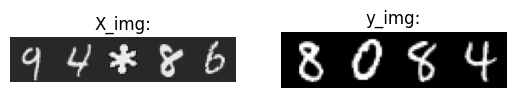

Query #4486

X_text: "44*86" = y_text: "3784"


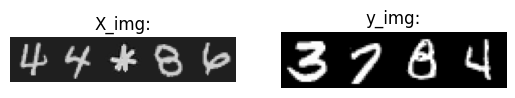

In [ ]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789* '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = 4 # Maximum length of the answer string (the longest resulting query string is '99*99'='10000 - 2*99 = 10000')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(highest_integer, operands=['*'])
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


## Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, image in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(image[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

# for _ in range(10):
#    display_sample(np.random.randint(0, 10000, 1)[0])

In [ ]:
######################################## text2text multiplication #################################################
def build_t2t_mult_model(additional_lstm=False, additional_decoder=False):
    in_shape = (5,12)                          # Input: 5 digits
    max_answer_length = 4                      # Output: 3 digits

    text2text = tf.keras.Sequential()

    if additional_lstm:                         # Three additional layers
        text2text.add(LSTM(512, input_shape=(None, len(unique_characters)), return_sequences=True))
        text2text.add(LSTM(512, return_sequences=True))
        text2text.add(LSTM(512, return_sequences=True))
        text2text.add(LSTM(512))

    else:
        text2text.add(LSTM(512, input_shape=(None, len(unique_characters))))

    text2text.add(RepeatVector(max_answer_length))

    text2text.add(LSTM(512, return_sequences=True))

    if additional_decoder:                      # Three additional layers
        text2text.add(LSTM(512, return_sequences=True))
        text2text.add(LSTM(512, return_sequences=True))
        text2text.add(LSTM(512, return_sequences=True))

    text2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))

    text2text.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

    text2text.summary()

    return text2text

def get_t2t_mult_split_data():                  # 90%-10% split
    train_cut = 9000
    val_cut = 9999
    X_text, X_img, y_text, y_img_ = create_data(highest_integer=99, operands=['*'])

    rng = np.random.default_rng(seed=123)
    indices = rng.permutation(len(y_text))
    X_text = encode_labels(X_text[indices])
    y_text = encode_labels(y_text[indices])

    X_train, X_val, X_test = X_text[:train_cut], X_text[train_cut:val_cut], X_text[val_cut:]
    y_train, y_val, y_test = y_text[:train_cut], y_text[train_cut:val_cut], y_text[val_cut:]

    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
t2t_mult_model = build_t2t_mult_model(additional_lstm=False, additional_decoder=False)
in_train, in_val, in_test, text_train, text_val, text_test = get_t2t_mult_split_data()
t2t_mult_history = t2t_mult_model.fit(in_train, text_train, epochs=100, validation_data=(in_val, text_val))             # Training: 100 epochs

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_99 (LSTM)              (None, 512)               1075200   
                                                                 
 repeat_vector_30 (RepeatVe  (None, 4, 512)            0         
 ctor)                                                           
                                                                 
 lstm_100 (LSTM)             (None, 4, 512)            2099200   
                                                                 
 time_distributed_30 (TimeD  (None, 4, 12)             6156      
 istributed)                                                     
                                                                 
Total params: 3180556 (12.13 MB)
Trainable params: 3180556 (12.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
2

In [ ]:
##################################### Image2text multiplication ########################################

def build_i2t_mult_model(additional_lstm=False, additional_decoder=False):
    image_shape = (5,28*28)               # Input: 5 images of 28x28 pixels
    max_answer_length = 4               # Output: 4 digits

    image2text = tf.keras.Sequential()
    if additional_lstm:                         # 1 additional layer
        image2text.add(LSTM(256, input_shape=image_shape, return_sequences=True))
        image2text.add(LSTM(256))

    else:
        image2text.add(LSTM(256, input_shape=image_shape))

    image2text.add(RepeatVector(max_answer_length))     # The RNN will always produce 3 characters as its output.
    image2text.add(LSTM(256, return_sequences=True))    # Setting return_sequences to True as TimeDistributed expects the first dimension to be the timesteps.

    if additional_decoder:                      # 1 additional layer
        image2text.add(LSTM(256, return_sequences=True))

    image2text.add(TimeDistributed(Dense(len(unique_characters), activation='softmax')))    # Apply a dense layer to the every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.

    image2text.compile(loss='mse', optimizer='nadam', metrics=['accuracy'])

    image2text.summary()
    return image2text

def get_i2t_mult_split_data():                      # 75%-25% split
    train_cut = 7500
    val_cut = 9999
    X_text, X_img, y_text, y_img_ = create_data(highest_integer=99, operands=['*'])

    rng = np.random.default_rng(seed=123)
    indices = rng.permutation(len(y_text))
    X_img = X_img[indices].reshape((-1, 5, 28*28))
    y_text = encode_labels(y_text[indices])

    X_train, X_val, X_test = X_img[:train_cut,:,:], X_img[train_cut:val_cut,:,:], X_img[val_cut:,:,:]
    y_train, y_val, y_test = y_text[:train_cut,:,:], y_text[train_cut:val_cut,:,:], y_text[val_cut:,:,:]

    return X_train, X_val, X_test, y_train, y_val, y_test



In [ ]:
i2t_mult_model = build_i2t_mult_model(additional_lstm=True, additional_decoder=True)
im_train, im_val, im_test, text_train, text_val, text_test = get_i2t_mult_split_data()
i2t_mult_history = i2t_mult_model.fit(im_train, text_train, epochs=100, validation_data=(im_val, text_val))         # Training: 100 epochs

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_101 (LSTM)             (None, 5, 256)            1065984   
                                                                 
 lstm_102 (LSTM)             (None, 256)               525312    
                                                                 
 repeat_vector_31 (RepeatVe  (None, 4, 256)            0         
 ctor)                                                           
                                                                 
 lstm_103 (LSTM)             (None, 4, 256)            525312    
                                                                 
 lstm_104 (LSTM)             (None, 4, 256)            525312    
                                                                 
 time_distributed_31 (TimeD  (None, 4, 12)             3084      
 istributed)                                         